Anzahl Klassen im Target: 4
label_majority
2.0    4876
1.0    1619
4.0    1322
3.0    1053
Name: count, dtype: int64
Training and evaluating classifiers...

Training Random Forest...
Accuracy: 0.7999
CV Score: 0.7903 (+/- 0.0282)

Training SVM (RBF)...
Accuracy: 0.7666
CV Score: 0.7582 (+/- 0.0207)

Training SVM (Linear)...
Accuracy: 0.7446
CV Score: 0.7439 (+/- 0.0297)

Training Logistic Regression...
Accuracy: 0.7413
CV Score: 0.7351 (+/- 0.0383)

Training K-Nearest Neighbors...
Accuracy: 0.7407
CV Score: 0.7363 (+/- 0.0096)

Training Decision Tree...
Accuracy: 0.7136
CV Score: 0.6946 (+/- 0.0124)

Training Gradient Boosting...
Accuracy: 0.7959
CV Score: 0.7896 (+/- 0.0190)

Training AdaBoost...
Accuracy: 0.7024
CV Score: 0.7032 (+/- 0.0347)

Training Naive Bayes...
Accuracy: 0.6054
CV Score: 0.6094 (+/- 0.0104)

Training Neural Network...
Accuracy: 0.7570
CV Score: 0.7444 (+/- 0.0116)

DETAILED CLASSIFICATION REPORTS

Classification Report for Random Forest:
------------------------

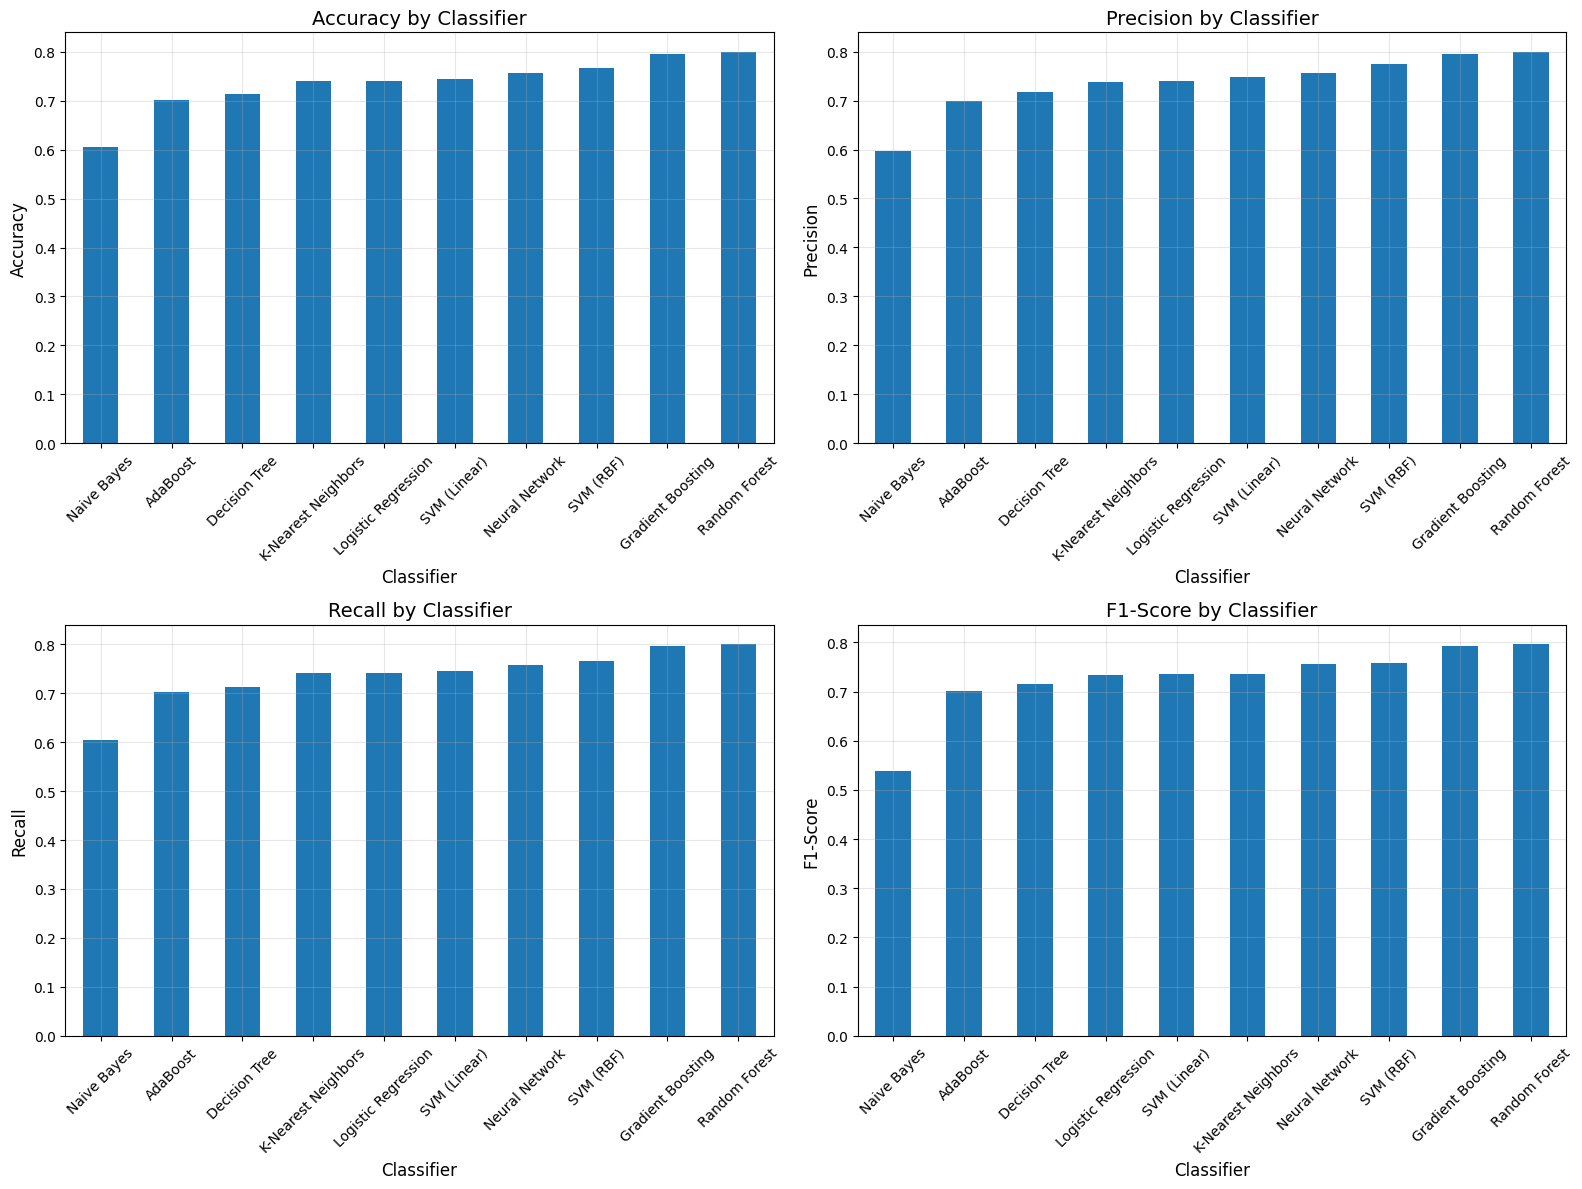

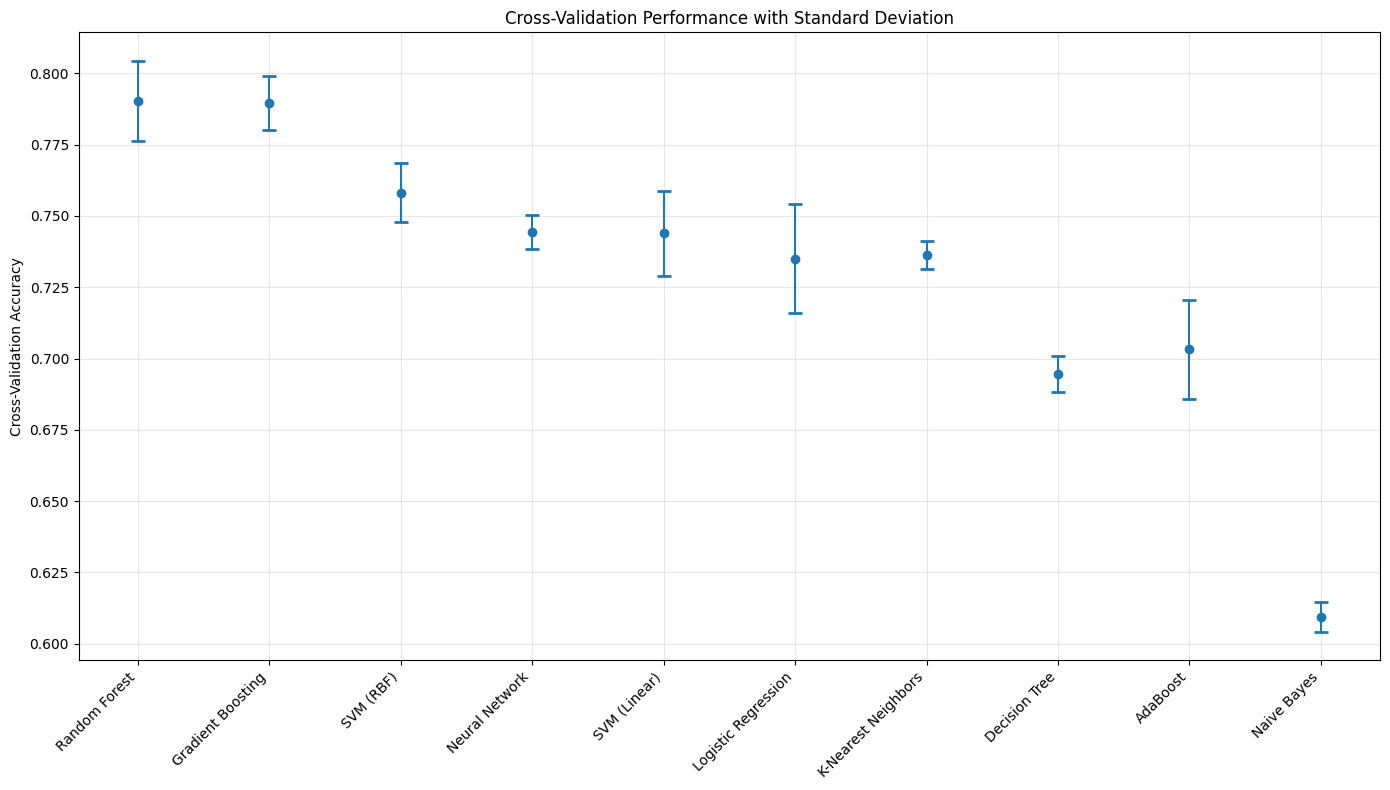

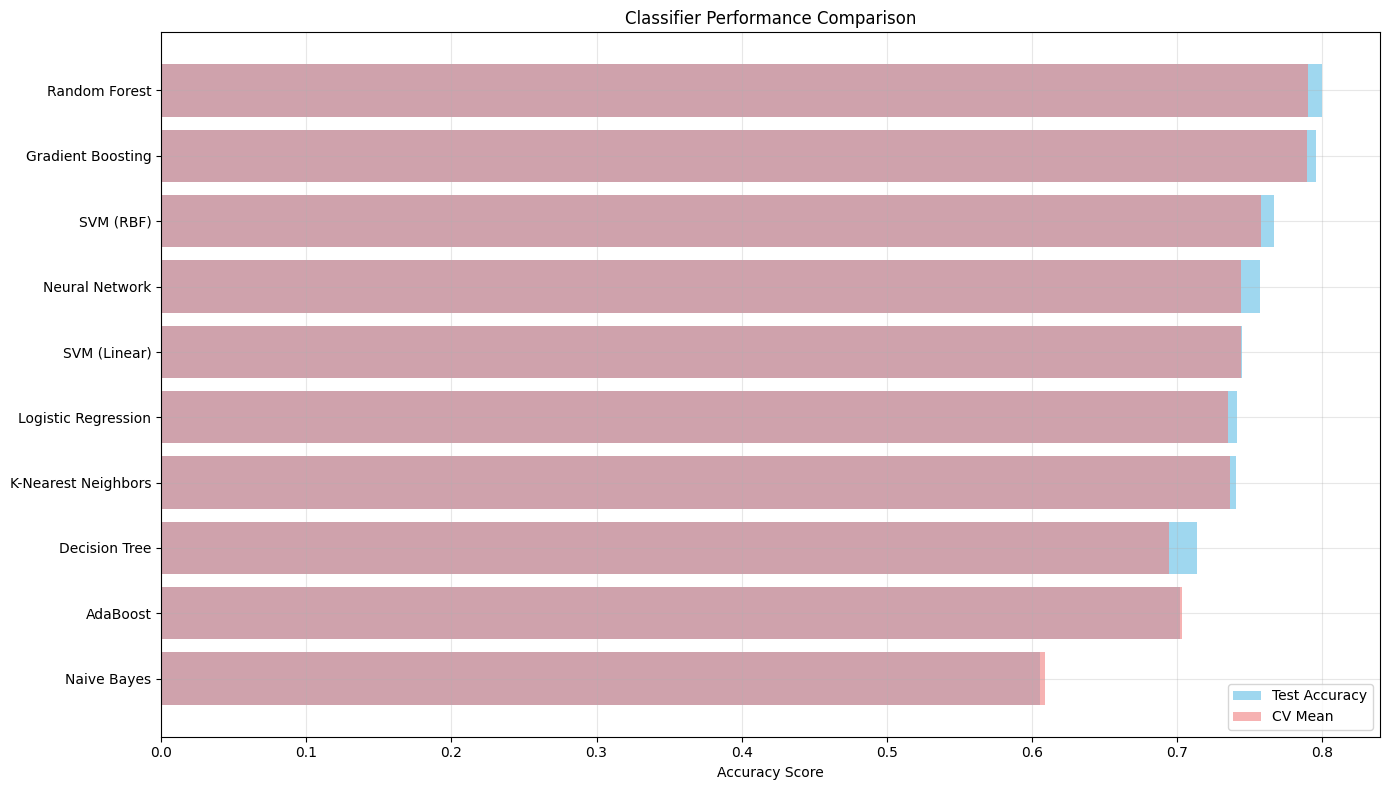

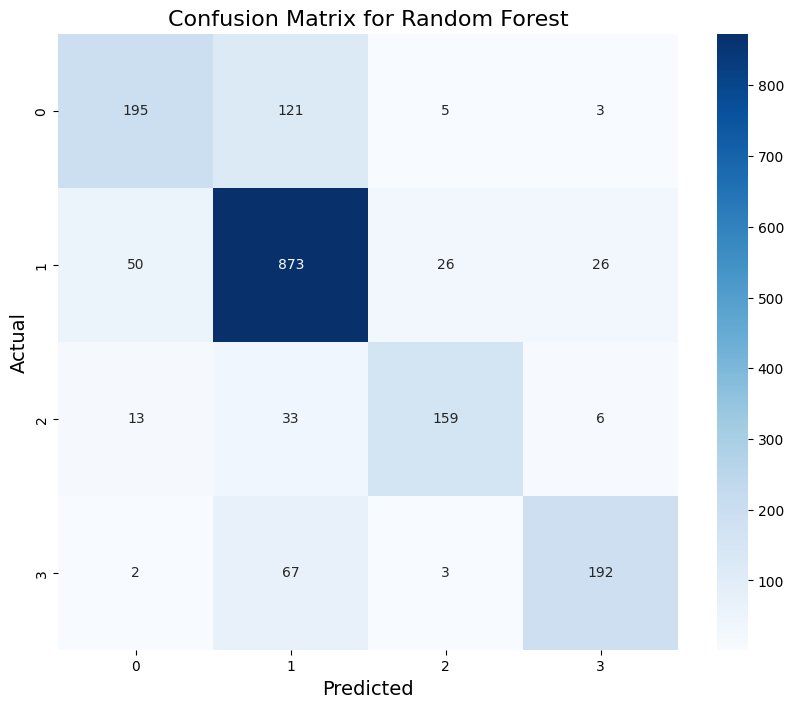

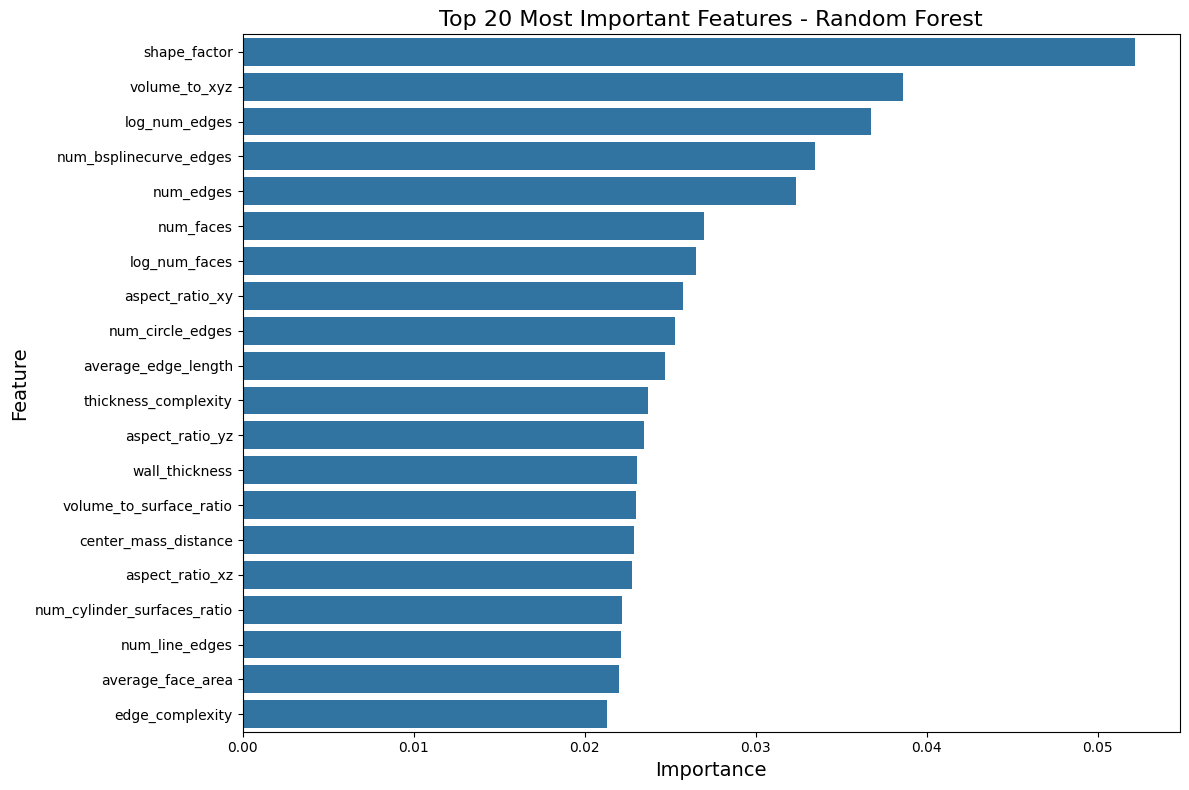


Performing hyperparameter tuning for top 5 classifiers...

Tuning Random Forest...
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Tuned accuracy: 0.7954

Tuning SVM (RBF)...
Best parameters: {'C': 10, 'gamma': 'auto'}
Tuned accuracy: 0.7745

Tuning SVM (Linear)...
Best parameters: {'C': 10}
Tuned accuracy: 0.7463

Tuning Logistic Regression...
Best parameters: {'C': 100, 'solver': 'lbfgs'}
Tuned accuracy: 0.7396

Tuning K-Nearest Neighbors...
Best parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Tuned accuracy: 0.7570

HYPERPARAMETER TUNING SUMMARY
                    Original Accuracy Tuned Accuracy Improvement
Random Forest                0.799887       0.795378    -0.00451
SVM (RBF)                    0.766629       0.774521    0.007892
SVM (Linear)                 0.744645       0.746336    0.001691
Logistic Regression          0.741263       0.739572   -0.001691
K-Nearest Neighbors          0.740699       0.757046    

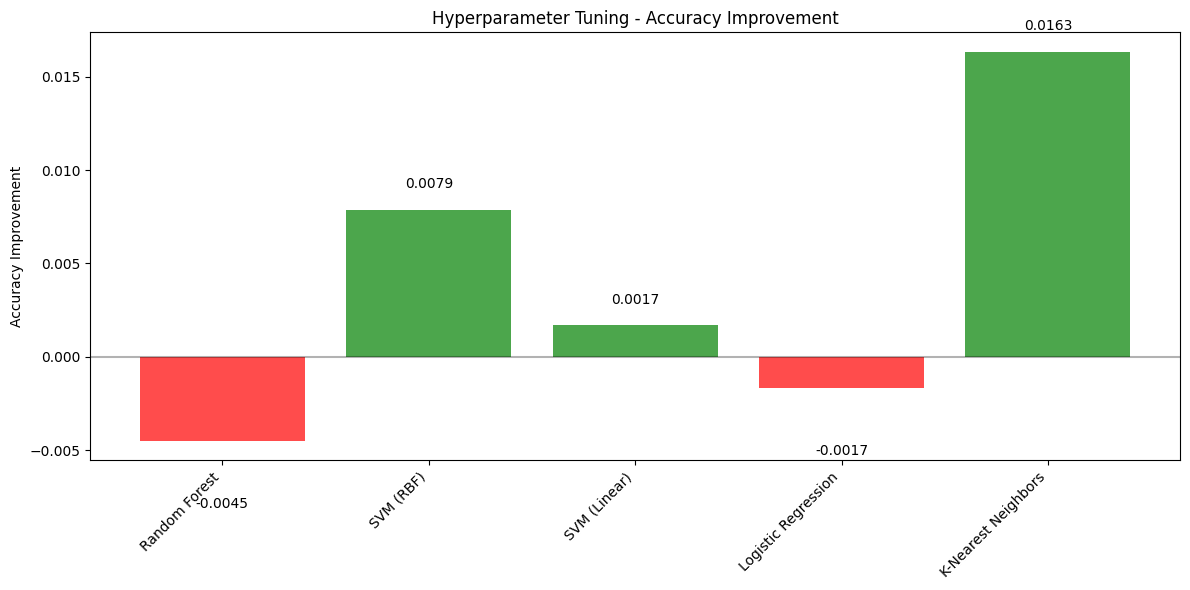


Analysis complete! All models have been evaluated and compared.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import gc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

warnings.filterwarnings('ignore')

class DataLoaderAndPreprocessor:
    def __init__(self, file_path, sample_size=None):
        self.file_path = file_path
        self.sample_size = sample_size

    def safe_divide(self, a, b):
        a = a.astype(np.float64)
        b = b.astype(np.float64)
        return np.divide(a, b, out=np.zeros_like(a, dtype=np.float64), where=b != 0)

    def calculate_features(self, data):
        data = data.copy()
        numeric_columns = data.select_dtypes(include=[np.number]).columns
        data[numeric_columns] = data[numeric_columns].astype(np.float64)

        features_to_calculate = [
            ('volume_to_surface_ratio', 'volume', 'surface_area'),
            ('edge_to_face_ratio', 'num_edges', 'num_faces'),
            ('average_face_area', 'surface_area', 'num_faces'),
            ('edge_complexity', 'num_edges', 'num_faces'),
            ('surface_complexity', 'num_unique_normals', 'num_faces'),
            ('thickness_complexity', 'wall_thickness', 'num_faces')
        ]

        for new_feat, num, denom in features_to_calculate:
            data[new_feat] = self.safe_divide(data[num].values, data[denom].values)

        data['average_edge_length'] = self.safe_divide(
            data[['x_dim', 'y_dim', 'z_dim']].sum(axis=1).values,
            data['num_edges'].values
        )

        volume_pow = np.power(data['volume'].values, 2/3)
        data['shape_factor'] = self.safe_divide(data['surface_area'].values, volume_pow)

        for prefix, columns in [
            ('edge', ['num_line_edges', 'num_circle_edges', 'num_ellipse_edges', 'num_bsplinecurve_edges']),
            ('surface', ['num_plane_surfaces', 'num_cylinder_surfaces', 'num_cone_surfaces',
                         'num_sphere_surfaces', 'num_torus_surfaces', 'num_bspline_surfaces'])
        ]:
            total = data[columns].sum(axis=1).values
            for col in columns:
                data[f'{col}_ratio'] = self.safe_divide(data[col].values, total)

        data['aspect_ratio_xy'] = self.safe_divide(data['x_dim'].values, data['y_dim'].values)
        data['aspect_ratio_xz'] = self.safe_divide(data['x_dim'].values, data['z_dim'].values)
        data['aspect_ratio_yz'] = self.safe_divide(data['y_dim'].values, data['z_dim'].values)

        xyz_product = data['x_dim'].values * data['y_dim'].values * data['z_dim'].values
        data['volume_to_xyz'] = self.safe_divide(data['volume'].values, xyz_product)
        data['surface_to_xyz'] = self.safe_divide(data['surface_area'].values, xyz_product)

        center_cols = ['x_center_mass_relative', 'y_center_mass_relative', 'z_center_mass_relative']
        center_mass_coords = data[center_cols].values - 0.5
        data['center_mass_distance'] = np.linalg.norm(center_mass_coords, axis=1)

        for col in ['volume', 'surface_area', 'num_faces', 'num_edges']:
            min_positive = max(data[col].min(), 1e-10)
            data[f'log_{col}'] = np.log1p(data[col].clip(lower=min_positive))

        complexity_cols = ['edge_complexity', 'surface_complexity', 'thickness_complexity']
        data['overall_complexity'] = data[complexity_cols].clip(lower=0).mean(axis=1)

        return data.replace([np.inf, -np.inf], 0).fillna(0)

    def load_data(self):
        df = pd.read_csv(self.file_path)
        df = df[(df['volume'] > 0) & (df['surface_area'] > 0)].copy()
        if 'filename' in df.columns:
            df.drop(columns=['filename'], inplace=True)

        if self.sample_size and self.sample_size < 1.0:
            df = df.groupby('label_majority').apply(
                lambda x: x.sample(frac=self.sample_size, random_state=42)
            ).reset_index(drop=True)

        df = self.calculate_features(df)
        print(f"Anzahl Klassen im Target: {df['label_majority'].nunique()}")
        print(df['label_majority'].value_counts())
        return df

class ClassifierEvaluator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.results = {}
        self.predictions = {}
        self.scaler = StandardScaler()
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, stratify=self.y, random_state=42
        )
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        
        # Erweiterte Liste aller Klassifikatoren
        self.classifiers = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'SVM (RBF)': SVC(kernel='rbf', random_state=42),
            'SVM (Linear)': SVC(kernel='linear', random_state=42),
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
            'Decision Tree': DecisionTreeClassifier(random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42),
            'AdaBoost': AdaBoostClassifier(random_state=42),
            'Naive Bayes': GaussianNB(),
            'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
        }

    def evaluate_classifiers(self):
        print("Training and evaluating classifiers...")
        print("=" * 60)
        
        for name, clf in self.classifiers.items():
            print(f"\nTraining {name}...")
            
            # Training und Vorhersage
            clf.fit(self.X_train_scaled, self.y_train)
            y_pred = clf.predict(self.X_test_scaled)
            self.predictions[name] = y_pred

            # Metriken berechnen
            accuracy = accuracy_score(self.y_test, y_pred)
            precision = precision_score(self.y_test, y_pred, average='weighted')
            recall = recall_score(self.y_test, y_pred, average='weighted')
            f1 = f1_score(self.y_test, y_pred, average='weighted')
            
            # Cross-Validation
            cv_scores = cross_val_score(clf, self.X_train_scaled, self.y_train, cv=5, scoring='accuracy')
            cv_mean = cv_scores.mean()
            cv_std = cv_scores.std()

            self.results[name] = {
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'CV Mean': cv_mean,
                'CV Std': cv_std
            }

            print(f"Accuracy: {accuracy:.4f}")
            print(f"CV Score: {cv_mean:.4f} (+/- {cv_std * 2:.4f})")

        # Detaillierte Berichte für alle Klassifikatoren
        print("\n" + "=" * 60)
        print("DETAILED CLASSIFICATION REPORTS")
        print("=" * 60)
        
        for name in self.classifiers.keys():
            print(f"\nClassification Report for {name}:")
            print("-" * 40)
            print(classification_report(self.y_test, self.predictions[name]))

        return pd.DataFrame(self.results).T.sort_values('Accuracy', ascending=False)

    def best_model_info(self):
        best_name = max(self.results, key=lambda k: self.results[k]['Accuracy'])
        return best_name, self.classifiers[best_name], self.predictions[best_name]

class Visualizer:
    def __init__(self, results_df, classifiers, predictions, y_test, X_train_scaled, X_test_scaled, y_train, feature_names):
        self.results_df = results_df
        self.classifiers = classifiers
        self.predictions = predictions
        self.y_test = y_test
        self.X_train_scaled = X_train_scaled
        self.X_test_scaled = X_test_scaled
        self.y_train = y_train
        self.feature_names = feature_names

    def plot_metrics(self):
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        for i, metric in enumerate(metrics):
            ax = axes[i // 2, i % 2]
            self.results_df.sort_values(metric).plot(y=metric, kind='bar', ax=ax, legend=False)
            ax.set_title(f"{metric} by Classifier", fontsize=14)
            ax.set_ylabel(metric, fontsize=12)
            ax.set_xlabel("Classifier", fontsize=12)
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_cv_scores(self):
        """Cross-Validation Scores mit Fehlerbalken"""
        plt.figure(figsize=(14, 8))
        names = list(self.results_df.index)
        cv_means = [self.results_df.loc[name, 'CV Mean'] for name in names]
        cv_stds = [self.results_df.loc[name, 'CV Std'] for name in names]

        plt.errorbar(range(len(names)), cv_means, yerr=cv_stds, fmt='o', capsize=5, capthick=2)
        plt.xticks(range(len(names)), names, rotation=45, ha='right')
        plt.ylabel('Cross-Validation Accuracy')
        plt.title('Cross-Validation Performance with Standard Deviation')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, best_name):
        y_pred = self.predictions[best_name]
        cm = confusion_matrix(self.y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix for {best_name}", fontsize=16)
        plt.xlabel("Predicted", fontsize=14)
        plt.ylabel("Actual", fontsize=14)
        plt.show()

    def plot_feature_importance(self, best_name):
        """Feature Importance für Modelle, die diese unterstützen"""
        best_model = self.classifiers[best_name]
        
        if hasattr(best_model, 'feature_importances_'):
            feature_importance = pd.DataFrame({
                'feature': self.feature_names,
                'importance': best_model.feature_importances_
            }).sort_values('importance', ascending=False)

            plt.figure(figsize=(12, 8))
            sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
            plt.title(f'Top 20 Most Important Features - {best_name}', fontsize=16)
            plt.xlabel('Importance', fontsize=14)
            plt.ylabel('Feature', fontsize=14)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Feature importance not available for {best_name}")

    def plot_results_comparison(self):
        """Übersichtliche Darstellung aller Ergebnisse"""
        plt.figure(figsize=(14, 8))
        
        # Sortiere nach Accuracy
        sorted_results = self.results_df.sort_values('Accuracy', ascending=True)
        
        # Erstelle horizontales Balkendiagramm
        y_pos = np.arange(len(sorted_results))
        
        plt.barh(y_pos, sorted_results['Accuracy'], alpha=0.8, color='skyblue', label='Test Accuracy')
        plt.barh(y_pos, sorted_results['CV Mean'], alpha=0.6, color='lightcoral', label='CV Mean')
        
        plt.yticks(y_pos, sorted_results.index)
        plt.xlabel('Accuracy Score')
        plt.title('Classifier Performance Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

class HyperparameterTuner:
    def __init__(self, classifiers, X_train, y_train, X_test, y_test):
        self.classifiers = classifiers
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.tuned_results = {}
        
        # Erweiterte Parameter-Grids für alle Klassifikatoren
        self.param_grids = {
            'Random Forest': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5, 10]
            },
            'SVM (RBF)': {
                'C': [0.1, 1, 10, 100],
                'gamma': ['scale', 'auto']
            },
            'SVM (Linear)': {
                'C': [0.1, 1, 10, 100]
            },
            'Logistic Regression': {
                'C': [0.1, 1, 10, 100],
                'solver': ['lbfgs', 'liblinear']
            },
            'K-Nearest Neighbors': {
                'n_neighbors': [3, 5, 7, 9],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']
            },
            'Decision Tree': {
                'max_depth': [None, 5, 10, 20],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            },
            'Gradient Boosting': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7]
            },
            'AdaBoost': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 1.0]
            },
            'Neural Network': {
                'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],
                'alpha': [0.0001, 0.001, 0.01],
                'learning_rate': ['constant', 'adaptive']
            }
        }

    def tune(self, top_n=5):
        """Hyperparameter-Tuning für die top N Klassifikatoren"""
        # Sortiere Klassifikatoren nach Performance
        classifier_names = list(self.classifiers.keys())
        
        # Führe Tuning nur für die verfügbaren Klassifikatoren durch
        classifiers_to_tune = [name for name in classifier_names if name in self.param_grids][:top_n]
        
        print(f"\nPerforming hyperparameter tuning for top {len(classifiers_to_tune)} classifiers...")
        print("=" * 60)
        
        for name in classifiers_to_tune:
            print(f"\nTuning {name}...")
            
            model = self.classifiers[name]
            param_grid = self.param_grids[name]
            
            # Grid Search mit reduzierter CV für Performance
            grid = GridSearchCV(
                model, 
                param_grid, 
                cv=3, 
                scoring='accuracy', 
                n_jobs=-1,
                verbose=0
            )
            
            grid.fit(self.X_train, self.y_train)
            
            # Evaluation des getunten Modells
            y_pred = grid.predict(self.X_test)
            tuned_accuracy = accuracy_score(self.y_test, y_pred)
            
            self.tuned_results[name] = {
                'Original Accuracy': accuracy_score(self.y_test, self.classifiers[name].fit(self.X_train, self.y_train).predict(self.X_test)),
                'Tuned Accuracy': tuned_accuracy,
                'Best Params': grid.best_params_,
                'Improvement': tuned_accuracy - accuracy_score(self.y_test, self.classifiers[name].fit(self.X_train, self.y_train).predict(self.X_test))
            }
            
            print(f"Best parameters: {grid.best_params_}")
            print(f"Tuned accuracy: {tuned_accuracy:.4f}")

        return self.create_tuning_summary()

    def create_tuning_summary(self):
        """Erstellt eine Zusammenfassung der Tuning-Ergebnisse"""
        if not self.tuned_results:
            return pd.DataFrame()
        
        tuning_df = pd.DataFrame(self.tuned_results).T
        tuning_df = tuning_df.round(4)
        
        return tuning_df[['Original Accuracy', 'Tuned Accuracy', 'Improvement']]

    def plot_tuning_improvements(self):
        """Visualisiert die Verbesserungen durch Hyperparameter-Tuning"""
        if not self.tuned_results:
            print("No tuning results available.")
            return
        
        plt.figure(figsize=(12, 6))
        names = list(self.tuned_results.keys())
        improvements = [self.tuned_results[name]['Improvement'] for name in names]
        
        colors = ['green' if imp > 0 else 'red' for imp in improvements]
        bars = plt.bar(names, improvements, color=colors, alpha=0.7)
        
        # Füge Werte auf den Balken hinzu
        for bar, imp in zip(bars, improvements):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.001 if height > 0 else height - 0.003,
                     f'{imp:.4f}', ha='center', va='bottom' if height > 0 else 'top')
        
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.ylabel('Accuracy Improvement')
        plt.title('Hyperparameter Tuning - Accuracy Improvement')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    # Hauptausführung
    file_path = r"C:\\Users\\meh91075\\Downloads\\features_newWallthickness_16092024.csv"
    data_handler = DataLoaderAndPreprocessor(file_path, sample_size=0.5)
    df = data_handler.load_data()

    # Features und Target vorbereiten
    X = df.drop(columns=['label_majority'])
    y = df['label_majority']
    feature_names = X.columns.tolist()

    # Evaluation aller Klassifikatoren
    evaluator = ClassifierEvaluator(X, y)
    results_df = evaluator.evaluate_classifiers()
    
    # Ergebnisse anzeigen
    print("\n" + "=" * 60)
    print("RESULTS SUMMARY")
    print("=" * 60)
    print(results_df.round(4))
    
    best_name, best_model, best_pred = evaluator.best_model_info()
    print(f"\nBest performing classifier: {best_name}")
    print(f"Best accuracy: {results_df.loc[best_name, 'Accuracy']:.4f}")

    # Visualisierungen
    visualizer = Visualizer(
        results_df, 
        evaluator.classifiers, 
        evaluator.predictions, 
        evaluator.y_test,
        evaluator.X_train_scaled,
        evaluator.X_test_scaled,
        evaluator.y_train,
        feature_names
    )
    
    visualizer.plot_metrics()
    visualizer.plot_cv_scores()
    visualizer.plot_results_comparison()
    visualizer.plot_confusion_matrix(best_name)
    visualizer.plot_feature_importance(best_name)

    # Hyperparameter-Tuning für Top 5 Klassifikatoren
    tuner = HyperparameterTuner(
        evaluator.classifiers, 
        evaluator.X_train_scaled, 
        evaluator.y_train, 
        evaluator.X_test_scaled, 
        evaluator.y_test
    )
    
    tuned_df = tuner.tune(top_n=5)
    
    if not tuned_df.empty:
        print("\n" + "=" * 60)
        print("HYPERPARAMETER TUNING SUMMARY")
        print("=" * 60)
        print(tuned_df)
        tuner.plot_tuning_improvements()

    print("\nAnalysis complete! All models have been evaluated and compared.")